<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
max_trials = 10
epochs = 10
tickers = ["BTC-USD", "%5EGSPC", "DX-Y.NYB", "GC=F", "XMR-USD"]

#Enter info regarding model

num_inputs=len(tickers)
look_back = 60
forward_days = 1
num_periods = 20

In [325]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate

In [326]:
#Ensuring the use of gpu tensorflow

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2022-12-19 16:48:22.725474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 16:48:22.725496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-19 16:48:22.725551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 16:48:22.725557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[*********************100%***********************]  1 of 1 completed


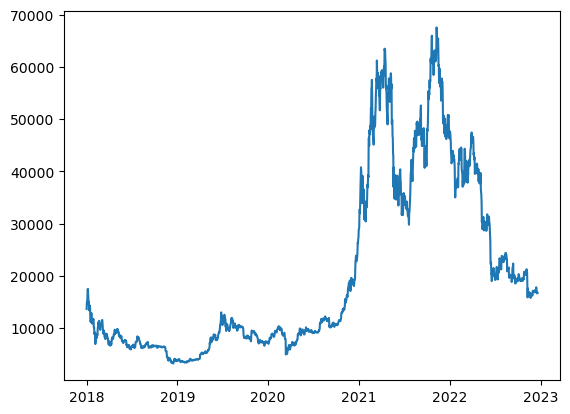

[*********************100%***********************]  1 of 1 completed


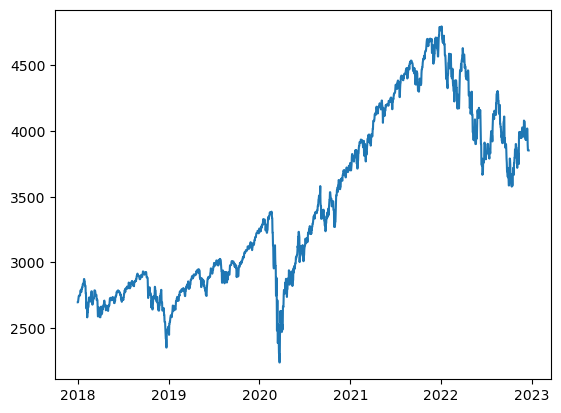

[*********************100%***********************]  1 of 1 completed


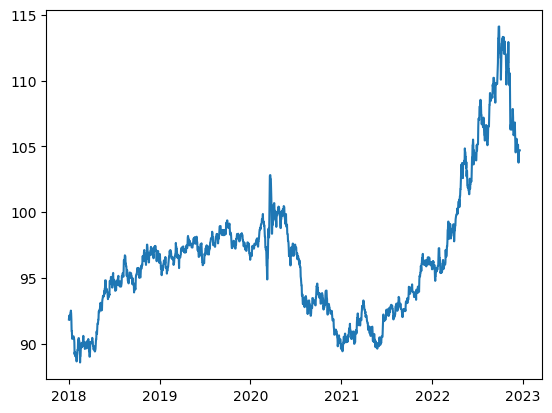

[*********************100%***********************]  1 of 1 completed


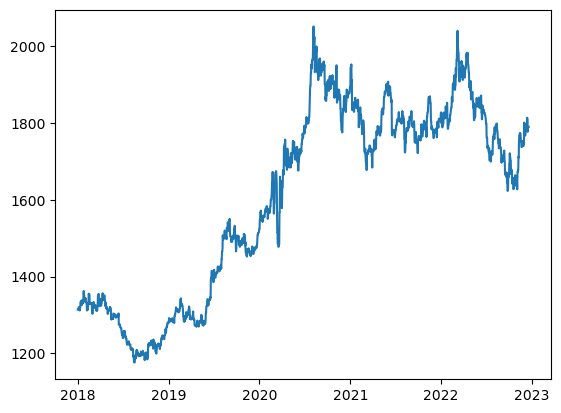

[*********************100%***********************]  1 of 1 completed


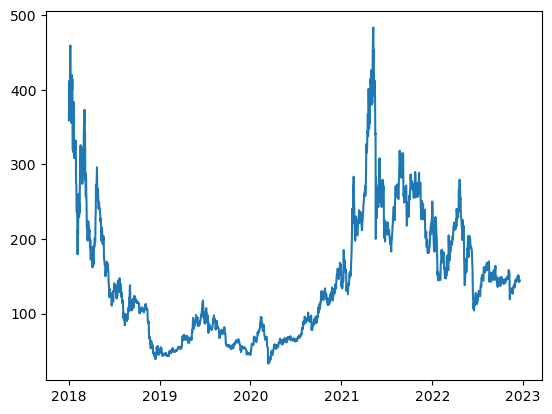

In [327]:
#data

today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2018-01-01', today)

timeseries = pd.DataFrame()

for item in tickers:
    df = yf.download(item, start="2018-01-01", end=today)["Close"]
    df = df.reindex(idx, fill_value=0, method="nearest")
    timeseries = pd.concat([timeseries, df], axis=1)
    plt.plot(df)
    plt.show()

In [328]:
timeseries.columns=(["close-" + n for n in tickers])
timeseries

,close-BTC-USD,close-%5EGSPC,close-DX-Y.NYB,close-GC=F,close-XMR-USD
2018-01-01,13657.200195,2695.810059,91.849998,1313.699951,358.989990
2018-01-02,14982.099609,2695.810059,91.849998,1313.699951,383.416992
2018-01-03,15201.000000,2713.060059,92.160004,1316.199951,412.062988
2018-01-04,15599.200195,2723.989990,91.849998,1319.400024,403.048004
2018-01-05,17429.500000,2743.149902,91.949997,1320.300049,384.936005
...,...,...,...,...,...
2022-12-15,17364.865234,3895.750000,104.559998,1777.199951,149.065460
2022-12-16,16647.484375,3852.360107,104.699997,1790.000000,142.141907
2022-12-17,16795.091797,3852.360107,104.699997,1790.000000,143.448380
2022-12-18,16757.976562,3852.360107,104.699997,1790.000000,144.340393


In [329]:
scaler = MinMaxScaler()

timeseries[["close-" + n for n in tickers]] = scaler.fit_transform(timeseries[["close-" + n for n in tickers]])

timeseries["close-BTC-USD-output"] = timeseries["close-BTC-USD"].shift(-1)
timeseries.drop(timeseries.tail(1).index, inplace=True)

array = timeseries.values

timeseries.head()

,close-BTC-USD,close-%5EGSPC,close-DX-Y.NYB,close-GC=F,close-XMR-USD,close-BTC-USD-output
2018-01-01 00:00:00,0.161984,0.179125,0.127743,0.157089,0.723478,0.182579
2018-01-02 00:00:00,0.182579,0.179125,0.127743,0.157089,0.777691,0.185982
2018-01-03 00:00:00,0.185982,0.185866,0.139891,0.159945,0.841267,0.192172
2018-01-04 00:00:00,0.192172,0.190137,0.127743,0.163601,0.821260,0.220624
2018-01-05 00:00:00,0.220624,0.197623,0.131661,0.164629,0.781062,0.222139


In [330]:
array[:5]

array([[0.16198395, 0.17912523, 0.12774301, 0.15708899, 0.72347756,
        0.18257929],
       [0.18257929, 0.17912523, 0.12774301, 0.15708899, 0.77769072,
        0.18598206],
       [0.18598206, 0.18586572, 0.13989055, 0.15994515, 0.84126749,
        0.19217201],
       [0.19217201, 0.19013663, 0.12774301, 0.16360113, 0.82125968,
        0.22062372],
       [0.22062372, 0.19762343, 0.13166144, 0.16462937, 0.78106201,
        0.22213934]])

In [331]:
#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division:]
array_train = array[:division]
# split into input and outputs
X_train, Y_train = array_train[:, :-1], array_train[:, -1]
X_test, Y_test = array_test[:, :-1], array_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.20)

In [332]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model

hypermodel = MyHyperModel(num_classes=1)    

In [333]:
# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=max_trials,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="models-temp")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=epochs,
             validation_data=(X_validate, Y_validate))

Trial 10 Complete [00h 00m 12s]
val_loss: 0.0002571013174019754

Best val_loss So Far: 0.0002446378639433533
Total elapsed time: 00h 01m 54s
INFO:tensorflow:Oracle triggered exit


In [334]:
#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

In [335]:
#Evaluate it on the validation test

print("Evalutation of best performing model:")
print(best_model.evaluate(X_validate, Y_validate))

Evalutation of best performing model:


2022-12-19 16:50:22.074450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-19 16:50:22.149234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 5s - loss: 3.3132e-04

2022-12-19 16:50:22.305097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 27ms/step - loss: 2.4464e-04
0.0002446378639433533


In [336]:
#Get summary

random_tuner.results_summary()

Results summary
Results in models-temp/lstm-kerastuner-multi
Showing 10 best trials
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
Score: 0.0002446378639433533
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.1
NUM_NEURONS_SecondLayer: 70
dropout_2: 0.30000000000000004
learning_rate: 0.01
Score: 0.0002511650382075459
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 30
dropout_2: 0.2
learning_rate: 0.01
Score: 0.0002571013174019754
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 80
dropout_1: 0.2
NUM_NEURONS_SecondLayer: 60
dropout_2: 0.1
learning_rate: 0.01
Score: 0.0002704183862078935
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 100
dropout_1: 0.4
NUM_NEURONS_SecondLayer: 50
dropout_2: 0.2
learning_rate: 0.01
Score: 0.00043226039269939065
Trial summary
Hyperparameters:
NUM_NEURONS_FirstLayer: 120
dropout_1: 0

In [337]:
#Saving the model

file_name = 'LSTM_BTC_tuned_multi.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_BTC_tuned_multi.h5` to disk


2022-12-19 16:50:23.025266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-19 16:50:23.099610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-19 16:50:23.196913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 439ms/step


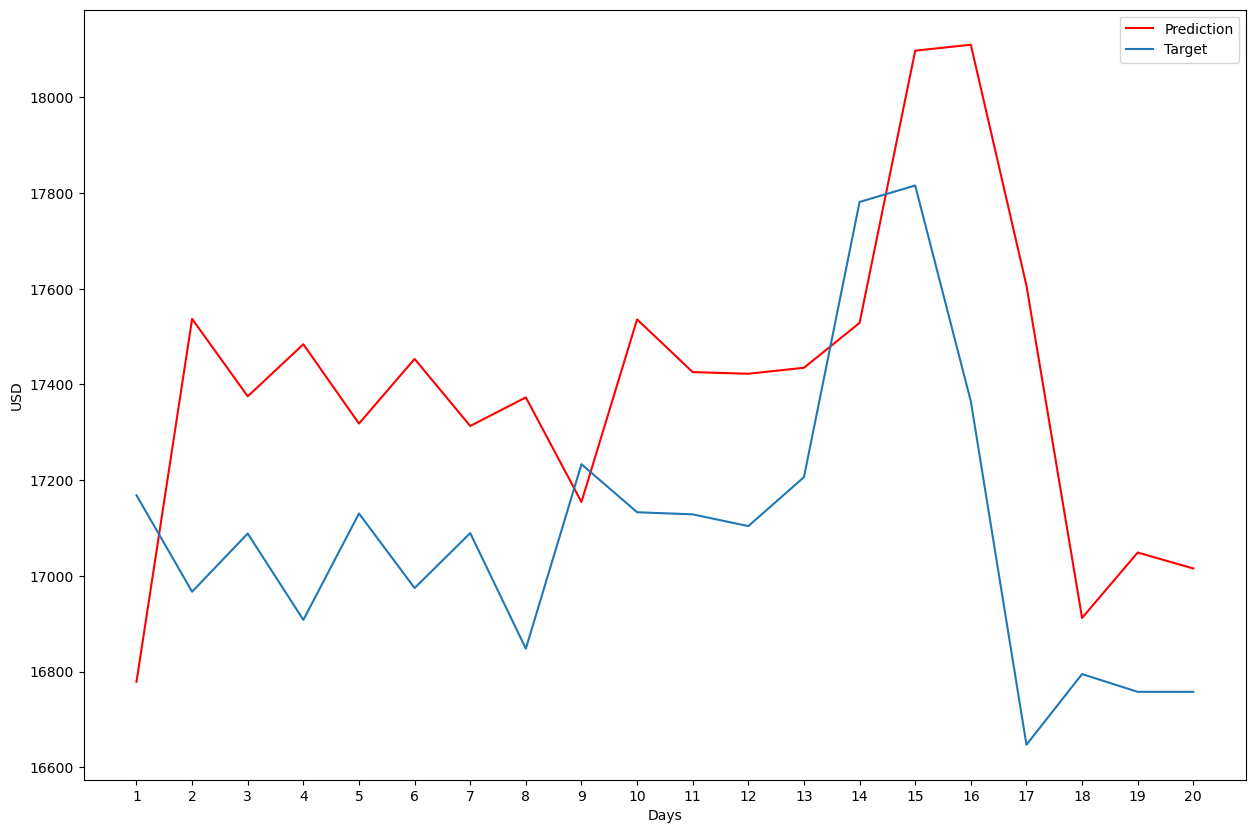

In [338]:
#Predict 

yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()